In [5]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from statsmodels.multivariate.pca import PCA
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd 

In [6]:
fname = join(os.getcwd(),'data','data3SS2009.mat')

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']


N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)




In [7]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts


    


In [9]:
ARmodel_2 = AutoReg(Ch2[:,1],30,old_names=False).fit()
ARmodel_3 = AutoReg(Ch3[:,1],30,old_names=False).fit()
ARmodel_4 = AutoReg(Ch4[:,1],30,old_names=False).fit()
ARmodel_5 = AutoReg(Ch5[:,1],30,old_names=False).fit()
vec_2 = ARmodel_2.params
vec_3 = ARmodel_3.params
vec_4 = ARmodel_4.params
vec_5 = ARmodel_5.params
vec_temp = np.concatenate((vec_2,vec_3,vec_4,vec_5))

ARmodel_var = vec_temp

for i in range(1,850):
    ARmodel_2 = AutoReg(Ch2[:,i],30,old_names=False).fit()
    ARmodel_3 = AutoReg(Ch3[:,i],30,old_names=False).fit()
    ARmodel_4 = AutoReg(Ch4[:,i],30,old_names=False).fit()
    ARmodel_5 = AutoReg(Ch5[:,i],30,old_names=False).fit()
    vec_2 = ARmodel_2.params
    vec_3 = ARmodel_3.params
    vec_4 = ARmodel_4.params
    vec_5 = ARmodel_5.params
    vec_temp = np.concatenate((vec_2,vec_3,vec_4,vec_5))
    ARmodel_var = np.vstack([ARmodel_var,vec_temp])

In [10]:
X = ARmodel_var
X.shape

(850, 124)

In [11]:
import numpy as np
from scipy import stats
from scipy.stats.stats import mode
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, RepeatedKFold,
RandomizedSearchCV)
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn.pipeline import Pipeline

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
ARmodel_reduced = pca.fit(ARmodel_var).transform(ARmodel_var)


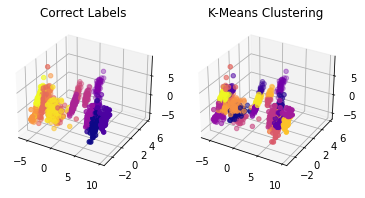

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

X = ARmodel_reduced
n_clusters = 24

kmeans = KMeans(n_clusters= n_clusters, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_


fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, marker='o', cmap='plasma')
ax1.set_title('Correct Labels')

ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, marker='o', cmap='plasma')
ax2.set_title('K-Means Clustering')


plt.show()


In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score

cluster_labels = kmeans.fit_predict(X)
cluster_to_majority_class = {}

for cluster in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    cluster_true_labels = y[cluster_indices]
    majority_class = np.bincount(cluster_true_labels).argmax()
    cluster_to_majority_class[cluster] = majority_class

assigned_labels = [cluster_to_majority_class[cluster] for cluster in cluster_labels]

confusion = confusion_matrix(y, assigned_labels)
accuracy = accuracy_score(y, assigned_labels)

print("Matrice de Confusion:")
print(confusion)
print(f": Précision {accuracy:.2f}")

Matrice de Confusion:
[[50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 49  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  3  0  0  0 42  4  0]
 [ 0  0  0  0  0  0  0  0  0  0 31  0  8  1  0  0 10]
 [ 0  0  0  0  0  0  0  0  0  0  7  0  9 31  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  1  0 31  3  0  0 15]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0 48  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0 16 33  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  0  1  2  0  0 44]]
: Précision 0.81


C:\Users\lxcas\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\lxcas\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


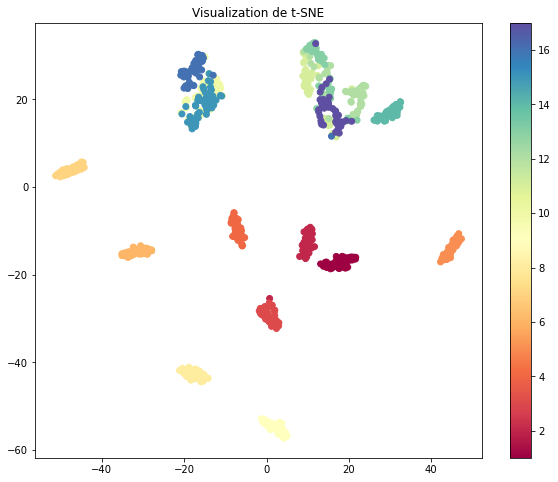

In [15]:
## Visualise dataset with t-SNE

X=ARmodel_reduced

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_2D = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y, cmap=plt.cm.Spectral) 
plt.title("Visualization de t-SNE")
plt.colorbar()
plt.show()

C:\Users\lxcas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lxcas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lxcas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lxcas\anaconda3\lib\site-packages\sklearn\metrics\_cla

Précision: 0.4117647058823529
Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00       184
           1       0.45      0.90      0.60       156

    accuracy                           0.41       340
   macro avg       0.15      0.30      0.20       340
weighted avg       0.20      0.41      0.27       340



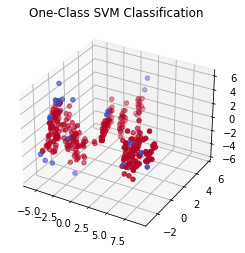

In [16]:
## Build a one-class classification SVM for nominal and failure modes

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder

#  1-9 is'undamaged' and 10-17 is 'damaged'
y_binary = np.where(y <= 9, 0, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.4, random_state=42)

clf = svm.OneClassSVM(kernel='rbf', nu=0.1)  
clf.fit(X_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Précision: {accuracy}')
print(f'Classification Report:\n{report}')

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_pred, cmap='coolwarm')
plt.title('One-Class SVM Classification')
plt.show()



C:\Users\lxcas\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\lxcas\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


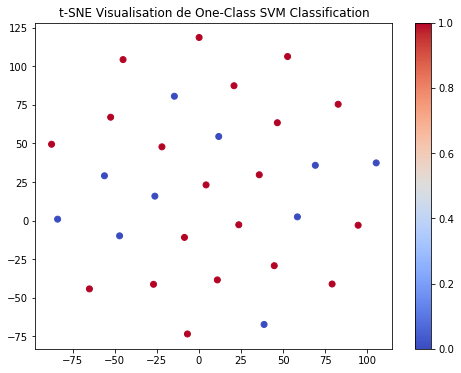

In [21]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_test)

# Visualize the t-SNE plot
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='coolwarm')
plt.title('t-SNE Visualisation de One-Class SVM Classification')
plt.colorbar()
plt.show()